# CNNs and RNNs

<iframe src="https://giphy.com/embed/22eVpVYpRhaE0" width="480" height="274" style="" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/dreamworks-shrek-donkey-22eVpVYpRhaE0">via GIPHY</a></p>

In this unit we will talk about the Convolution Neural Network (CNN) and Recurrent Neural Network (RNN), as well as introducing how you can build them through using the module pytorch. 

# The Convolution

In order to understand a CNN it is worth spending some time talking about the convolution. 

The idea of a convolution is to pass one system through another to get the characteristics of how they interact. If a system is thought of as a function, it is the idea of taking every output of each function for every input and combining them in some way. In our case we can simulate this by passing a kernel over our image. On initialization the kernel has random values, but the values can be learned through the training process. 

In our examples we will be used a 2 dimensional kernel, but kernels can be 1, 3, and more dimensions. 

A 2d kernel can be represented like a grid shown below, it has a shape, and each block in the grid contains a numeric value:

<insert image of grid with random values and shapes>

As a kernel is passed over data, the value in each kernel cell will be mathematically combined with a value of data in some way. Usually we multiply them. Then once that is done for every kernel value and corresponding data value the collection of output is combined together, usually by adding, and spit out as a single data value. 

Image of Kernel Convolution:

<img src="./images/kernel_convolution.png" width="600">

Here is a great example animation by wikipedia:
https://en.wikipedia.org/wiki/File:2D_Convolution_Animation.gif

How far the kernel is moved after each step is called the stride. 

One important aspect to note and not shown in the animation, is that if a kernel is passed over an image the output size will be reduced based on the kernel's size. 

The reduction in size can be expressed by this equation: 

n x n convolved with f x f = (n - f + 1) x (n - f + 1)

The kernel acts as a way to consolidate information as it passes throughout the model. The output of the kernel and the data is known as a feature map. This creates a "high level features" on our feature map. It can be thought of as finding higher level patterns in our data. The more kernels we have the "features" we tend to learn.

Large kernels can learn more global patterns or high level details, while small kernels can help learn more detailed patterns. 

As the feature map information is passed through multiple kernels, a single value later down the network represents many values closer to the input of the feature map.

Alexnet Architecture for Reference:

<img src="./images/alexnet_arch.png" width="600">

Alexnet is a convocational neural net that takes in image data. Here the diagram shows the internal architecture of how it is built. In the diagram the orange squares represent data and its dimensions. The yellow boxes show the kernels and their sizes. The orange boxes change in size based on the number of kernels that are used - these are stacked on top of each other to get the new size. The activation function is usually applied at the output of the kernel convolution. The "FC" layers are the "fully connected layers" like the MLP we discussed in a previous lecture.

Note at the time this model was considered to be so big they did all the training on two GPUs separately, the architecture on the two GPUs can be seen in the paper in the citations.

<img src="./images/kernel_output_stacking.png" width="600">

One great aspect of kernels is the variety of uses they have outside of machine learning too, here are some pretty cool examples:
Interesting Kernels: https://en.wikipedia.org/wiki/Kernel_(image_processing)


Citations and Useful Links on Convolutions and Kernels:
- https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html
- https://www.striveworks.com/blog/demystifying-computer-vision-the-power-of-convolution-in-neural-networks#:~:text=What%20Is%20Convolution%3F
- https://www.youtube.com/watch?v=kebSR2Ph7zg
- https://medium.com/@abhishekjainindore24/all-about-convolutions-kernels-features-in-cnn-c656616390a1
- https://stackoverflow.com/questions/56652204/pytorch-convolution-in-channels-and-out-channels-meaning
- https://paperswithcode.com/method/alexnet
- https://viso.ai/deep-learning/alexnet/


# Neural Networks with Pytorch - a CNN Example

Pytorch is a machine learning library created by Facebook/Meta, it is open source and created under the Linux Foundation. This along with TensorFlow is one of the most powerful open source machine learning libraries available. You can learn more about pytorch in the link below.

https://pytorch.org/


Pytorch as many of the same steps as scikit learn, however since pytorch's power comes from its ability to be more granular, there is a bit more setup involved. However, this gives us much more flexibility on our data. 

1. Import the data
2. Setup the dataset class
3. Feed into a data loader
4. Build your model
5. Train your model
6. Evaluate the results

There are many many resources online, so I encourage you to look at examples! 

Pytorch relies heavily on you to create classes, so if you are a bit rusty please check out online resources for class creation in python.

In [1]:
# Example inspired heavily from https://www.kaggle.com/code/tiiktak/fashion-mnist-with-alexnet-in-pytorch-92-accuracy
# 1. Import the data
# Data source: https://www.kaggle.com/datasets/zalando-research/fashionmnist?resource=download

import zipfile
import torch
# Unzip the Data
with zipfile.ZipFile('./fashion-mnist_test.csv.zip', 'r') as zip:
    zip.extractall('fashion-mnist_test')

with zipfile.ZipFile('./fashion-mnist_train.csv.zip', 'r') as zip:
    zip.extractall('fashion-mnist_train')

import pandas as pd

fashion_train_csv = pd.read_csv('./fashion-mnist_train/fashion-mnist_train.csv')
fashion_test_csv = pd.read_csv('./fashion-mnist_test/fashion-mnist_test.csv')

CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [2]:
# Setup for Datasets
print(fashion_train_csv.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [3]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        # Is there a better way to do this :)
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label
    
from torchvision import transforms, datasets
# Feed into our dataset

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

fashion_train_dataset = FashionDataset(fashion_train_csv, preprocess)
fashion_test_dataset = FashionDataset(fashion_test_csv, preprocess)


In [4]:
from torch.utils.data import DataLoader
# Feed into a data loader
BATCH_SIZE = 4
fashion_train_loader = DataLoader(fashion_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=BATCH_SIZE, shuffle=True) 

torch.Size([4, 1, 28, 28])
torch.Size([4])


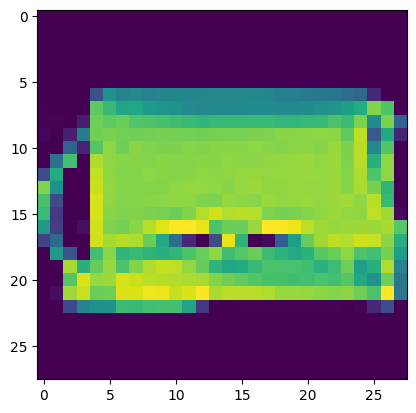

Bag


In [5]:
# Visualize Data
import matplotlib.pyplot as plt
for batch, labels in fashion_train_loader:
    print(batch.shape)
    print(labels.shape)
    # Unnormize batch
    batch = batch/2 + 0.5
    plt.figure()
    plt.imshow(batch[0].squeeze())
    plt.show()
    print( CLASS_NAMES[int(labels[0])])
    break

In [6]:
# Build the model
import torch.nn as nn
# There is a lot of nuance here


class fashion_mnist_model(nn.Module):
    def __init__(self):
        super(fashion_mnist_model, self).__init__()
        # Create the layers we want to use
        # Made these up for this example

        # Convolutional layer what has 1 input channel - since our images are grayscale
        # Note we do not have to specify the image size here. 
        # It will then create 10 kernels 3x3 - this determines our number of out channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3)
        # Output will be 10 here for the 10 classes. We want to see the 
        # probability of what the image input is for each class.
        self.fc1 = nn.Linear(in_features=22 * 22, out_features=10)
        self.relu = nn.ReLU()


    def forward(self, x : torch.Tensor):
        # Use the layers we created to do a feed forward of our data
        # This is the actual model architecture
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

import torch.nn.functional as F
# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Look at all of these hyperparameters we can change!

model = fashion_mnist_model()
model.eval() # This locks our model and prevents training
for batch, labels in fashion_train_loader:
    out = model(batch)
    print(out.shape)
    break

torch.Size([4, 10])


In [7]:
# Training the Model
import datetime
# There are a few extra steps in training our model, such as 
# Determining our loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Determine the number of epochs
EPOCHS = 3
# (Optional but very helpful) tracking loss
running_loss = 0
last_lost = 0
running_loss_log = []
epoch_loss = 0
epoch_loss_log = []
# Make model
fashion_model = fashion_mnist_model()
# Setup for training
fashion_model.train(True)
# Determining our optimizer
optimizer = torch.optim.SGD(fashion_model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}")
    for i, batch in enumerate(fashion_train_loader):
        inputs, labels = batch
        # Zero out gradients
        optimizer.zero_grad()
        # Make predictions
        outputs = fashion_model(inputs)
        # Calculate loss on expected data and gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Report loss
        # Gather data and report
        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 100
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss_log.append(last_loss)
            running_loss = 0
    epoch_loss_log.append(epoch_loss)
    epoch_loss = 0
    time_now = datetime.datetime.now()
    model_path = './model_{}_{}_{}_{}'.format(time_now.hour, time_now.minute, time_now.second, epoch)
    torch.save(fashion_model.state_dict(), model_path)
# It is also a good idea to save a model locally, that way it is
# not lost if your computer turns off, or you can continue training
# it later 

# Model can be loaded by:
#saved_model = fashion_mnist_model()
#saved_model.load_state_dict(torch.load(PATH))

Epoch 1
  batch 1000 loss: 9.305831701047719
  batch 2000 loss: 6.54067083820235
  batch 3000 loss: 5.8627030742634085
  batch 4000 loss: 5.527617590356385
  batch 5000 loss: 5.281466858079657
  batch 6000 loss: 5.330240527526476
  batch 7000 loss: 5.065294398886618
  batch 8000 loss: 5.239774256140226
  batch 9000 loss: 4.833436463177204
  batch 10000 loss: 4.923963478585356
  batch 11000 loss: 5.0040256604354365
  batch 12000 loss: 4.981124955494888
  batch 13000 loss: 4.855097348996205
  batch 14000 loss: 4.430760517388117
  batch 15000 loss: 4.661647411519661
Epoch 2
  batch 1000 loss: 4.425845007284079
  batch 2000 loss: 4.63483608065988
  batch 3000 loss: 4.678203185441671
  batch 4000 loss: 4.489301058297278
  batch 5000 loss: 4.533395206421265
  batch 6000 loss: 4.470290048109018
  batch 7000 loss: 4.273082796062808
  batch 8000 loss: 4.40278722044779
  batch 9000 loss: 4.2168359743634936
  batch 10000 loss: 4.396019470237079
  batch 11000 loss: 4.455667018299282
  batch 12000 

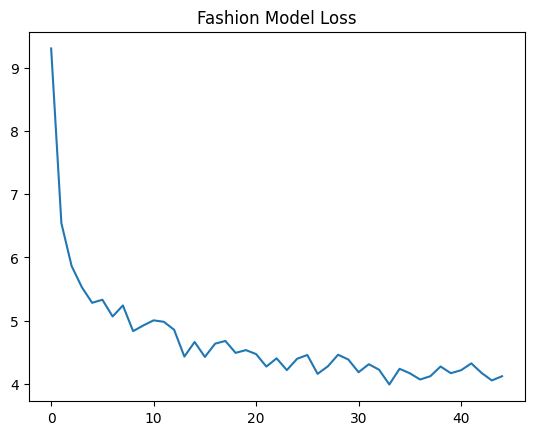

In [8]:
# Evaluating the Model
plt.figure()
plt.title("Fashion Model Loss")
plt.plot(running_loss_log)
plt.show()

In [ ]:
# Evaluate Mode
fashion_mnist_model.eval() # Prevents training
total_samples = 0
total_correct = 0
with torch.no_grad():
    for i, batch in enumerate(fashion_test_loader):
        inputs, labels = batch
        outputs = fashion_mnist_model(inputs)
        # Use the softmax eq to get the class label
        


# Recurrent Neural Network (RNN)

The idea of a RNN is there may be information in previous layers that may be lost throughout the model as it passes through each layer. 

The general architecture can be seen here:


Citations:
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/
- 


In [9]:
#

# AlexNet Example (Optional example)

One useful aspect of pytorch is we can use existing models provided. Granted these are academic model, but they allow us to use the structures right out of the box. We can then train on data without setup for the model. We still need to setup unpacking our data and loading it into datasets, but this way we dont need to create a model object from scratch. 



In [10]:
from torchvision.models import AlexNet, AlexNet_Weights
from torchvision import transforms
import torchvision
import torch
# Get the dataset ready
# Wnat to use mnist dataset I think 

# TODO: Get the test dataset out and 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3, ),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.5], std=[0.25]),
    
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                           transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)



# Note if you had your own data you would want to use 
#torch.utils.data.Dataset OR torch.utils.data.TensorDataset(X, y)
#torch.utils.data.DataLoader(input_dataset, batch_size, etc)

# For torch.utils.data.Dataset() you will need to make a class 
# you must make a __init__, __len__ and __getitem__ methods before it can be used
# See example here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html




torch.Size([64, 3, 224, 224])
tensor(0)


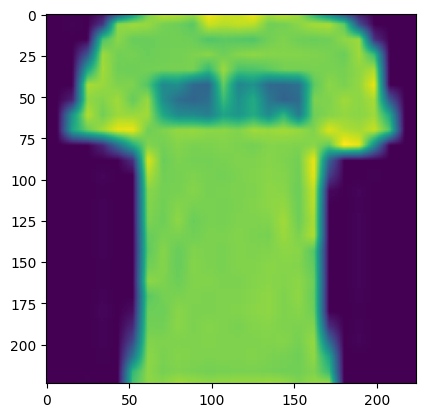

In [11]:
# Visualize the Data
import matplotlib.pyplot as plt
for batch, label in train_loader:
    print(batch.shape)
    print(label[0])
    plt.imshow(batch[0].squeeze()[0])
    break
    

In [12]:
from torchvision.models import alexnet, AlexNet_Weights

# Load the model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# Set it to eval mode to prevent learning
model.eval()

for batch, label in train_loader:

    output = model(batch)
    print(output[0])
    print(label[0])
    break

Using cache found in C:\Users\trent/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\trent\Documents\DSC412\units\unit-8-cnns-rnns\unit-8-venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\trent\Documents\DSC412\units\unit-8-cnns-rnns\unit-8-venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([ 7.2181e-01,  1.3744e+00, -3.0177e-01,  5.9084e-01, -5.6439e-01,
         4.1507e+00, -3.2499e+00, -6.8271e-01, -2.5967e+00, -2.1571e+00,
         4.4283e+00, -3.3050e+00, -4.1619e+00, -1.4684e+00, -4.1394e+00,
        -2.5378e+00, -1.7554e+00, -3.7811e+00, -4.2977e+00, -3.7934e+00,
         8.0970e-01, -8.9682e-01, -3.2532e+00, -2.4150e+00, -7.9541e-01,
         6.1366e-01,  1.6135e+00,  3.9895e-01,  3.6253e+00,  3.8768e+00,
        -1.6065e+00,  1.3587e+00,  1.5460e+00, -4.1055e-03,  1.2378e+00,
        -2.8190e+00,  5.0702e-01, -6.5534e+00,  4.7529e+00, -1.8575e+00,
        -3.3784e+00,  1.0227e+00,  2.3089e-01,  4.4169e+00, -1.8793e+00,
        -9.3798e-01, -3.9003e+00,  2.8475e-02, -1.8082e+00, -1.8617e+00,
        -1.9452e+00,  3.8080e+00,  3.8617e-02, -5.8373e-01, -1.4896e+00,
        -3.3603e+00, -5.5586e-01, -3.0187e+00, -3.3838e+00,  5.4130e+00,
         1.4933e+00, -3.0274e+00,  5.3442e+00,  1.9968e+00,  1.8652e+00,
        -2.0997e-01,  3.9023e+00, -3.9824e+00,  5.5

# Recurrent Neural Networks (RNN)

In [13]:
training_set = torchvision.datasets.FashionMNIST('./data', train=True, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
for batch in train_loader:
    inputs, labels = batch
    print(labels.shape)
    print(labels[0])
    break

torch.Size([64])
tensor(8)
